 <h1><center> Discussing the Covid19 Pandemic </center></h1>
  <h2><center> Topic Modeling Book 1 </center></h2>


**Student: Shreyas Chitransh     
Course: BrainStation DataScience and AI Bootcamp  
Project: Capstone
Notebook: Part 3 of 4    
Previous Notebook: Part 2 - Tweet Exploratory Data Analysis    
Next Notebook: Part 4 - Topic Modeling Book 2**


## Introduction

In the first part of the report, the overall data was imported and cleaned and a basic Exploratory Data Analysis (EDA) performed. The second part of the report conducted EDA specifically for the text of the Tweets and gave us insights which will now help us to implement our Topic Modeling workflow efficiently. The learning from the text EDA are: 
 - The Tweets need to be cleaned by removing `stopwords`, `links`, `&amp`, `dashes` and `dots`
 - The Tweets have a lot of synonyms of Covid19 such as 'covid_19', 'coronavirus' or ' covid' which *may* need to be aggregated and changed to a singular word
 - The 'mentions' using `@` *may* have to be removed
 
The above bullet points emphasise `may` as there might be better results if the step is omitted. Whereas in a regular modeling workflow there are hyperparameters that need to be tuned for improved results, in Natural Language Processing (NLP) Topic Modeling there are very few optional hyperparameters. The `alpha` and `eta` hyperparameters are more relevant when the author has a-priori knowledge about the number of topics expected or word probability. In our case, we have to change the input data by varying preprocessing steps as well as the number of topics in order to yield different (potentially better) results.


As discussed at the end of part 2, we will have to generate the corpus for the Latent Dirichlet Allocation (LDA) model in a different manner than the corpora generated for EDA in part 2. Therefore we will re-import `analysis_df`, which contains the cleaned data from part 1, and start the preprocessing for the modeling. 

## Importing the Data Subset 

After importing `analysis_df` we will check to ensure there are no errors with the data.

### Importing

The first step is to import all modules and libraries which will be used throughout this part. Then the dataframe will be imported.

In [1]:
# Make sure to install using: 
# pip install gensim==3.8.3

In [2]:
# Import the relevant libraries and modules which will be utilized in the overall report
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
from collections import Counter
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel
import warnings 
from wordcloud import WordCloud
from pprint import pprint
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\shch9\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


Now the data will be imported below. 

In [3]:
# import the data exported at the end of part 1
analysis_df= pd.read_csv(r'data\analysis_df.csv', index_col=0)

We loaded this dataset in part 2 and checked it, however it's best practice to check it again after loading, in case there were data corruption issues or the data got re-written. Let's have a look at our data.

In [4]:
# Check the first 5 rows of the dataframe
analysis_df.head()

,created_at,screen_name,text,is_retweet,favourites_count,retweet_count,followers_count,friends_count,verified
0,2020-03-29 00:00:00+00:00,rlieving,“People are just storing up. They are staying ...,False,604,0,136,457,False
1,2020-03-29 00:00:11+00:00,wgbhnews,Dez-Ann Romain was a beloved school principal....,False,2200,2,32264,5029,True
2,2020-03-29 00:00:30+00:00,FortesHealth,As part of your everyday #prevention actions c...,False,5,0,2,10,False
3,2020-03-29 00:01:01+00:00,LinnieElle,@realDonaldTrump #Trump please #ResignNowtrump...,False,107402,0,4291,4755,False
4,2020-03-29 00:01:38+00:00,TomStrudwick93,I don’t think we realised how good we had it b...,False,4805,0,337,398,False


 Let's check the structure and rows to ensure that we still have the 81,333 rows with 9 columns. 

In [5]:
# Check the structure of the of the dataframe to ensure it is correct
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81333 entries, 0 to 81332
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   created_at        81333 non-null  object
 1   screen_name       81333 non-null  object
 2   text              81333 non-null  object
 3   is_retweet        81333 non-null  bool  
 4   favourites_count  81333 non-null  int64 
 5   retweet_count     81333 non-null  int64 
 6   followers_count   81333 non-null  int64 
 7   friends_count     81333 non-null  int64 
 8   verified          81333 non-null  bool  
dtypes: bool(2), int64(4), object(3)
memory usage: 5.1+ MB


We can see that the dataframe contains 9 columns and 81,333 rows. Now that we have ensured that the dataset is imported correctly, let's start the Topic Modeling for models 1 & 2.

## Topic Modeling and Exploration with pyLDAvis Models 1 & 2

Now that we have a better understanding of our dataset from the EDA, we will use Topic Modeling to find out the topics being discussed in the Tweets. Topic Modeling is an unsupervised machine learning technique that can extract the main topics in a collection of documents which in our case are individual tweet records. We will be utilizing LDA (Latent Dirichlet Allocation) for the Topic Modeling.

In the Journal of Machine Learning Research, <a href="https://www.researchgate.net/publication/220319974_Latent_Dirichlet_Allocation">Blei et. al.</a> describe LDA, as a generative probabilistic model for collections of discrete data such as text corpora. It is a three-level hierarchical Bayesian model, in which each item of a collection is modeled as a finite mixture over an underlying set of topics. Each topic is, in turn, modeled as an infinite mixture over an underlying set of topic probabilities. In the context of text modeling, the topic probabilities provide an explicit representation of a document. Simply put, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics.

Our Topic Modeling workflow will be conducted using LDA and visualized using pyLDAvis. In pyLDAvis, the 'py' refers to python, 'LDA' refers to Latent Dirichlet Allocation and 'vis' refers to visualization. 


### Generating LDA  Corpus With Covid19 Synonyms   <a id="1"></a>

As mentioned earlier, we will start the process from the original analysis data subset itself. For ease of explanation, the corpus we are generating for analysis will be called `corpus_LDA_with_Covid19_synonyms`. This is because, in the first model we are not be removing or replacing the synonyms of Covid19. 

#### Preprocessing Tweet Text

In our analysis workflow, the first step will be to generate a function to preprocess the Tweets for our dataset and convert the text into a corpus. Further,the preprocessing will involve tokenization, lemmatization and removing stopwords. While in machine learning NLP workflow stemming can play a role to improve modeling, we are not going to stem our terms due to the terms losing their meaning. This is because stemming can generate incorrect words. 

 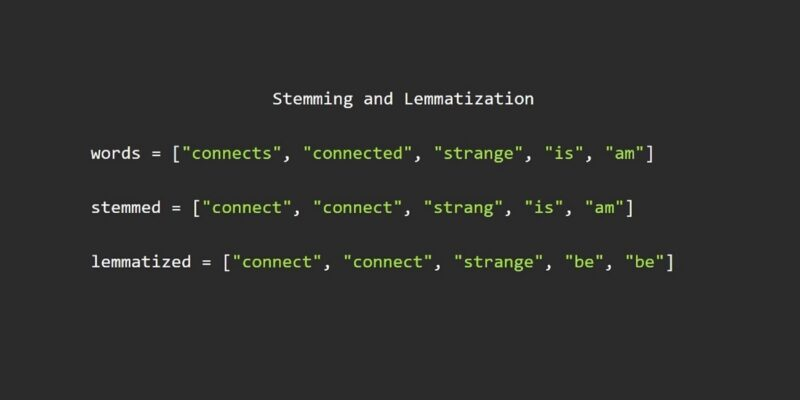
 
 
In the example above, we can see that by using a lemmatizer we can remove the plurals of a word and bring it to a lemma while preserving word meaning whereas stemming can lead to incorrect words being generated. Therefore we will not be using a stemmer and only using a lemmatizer for preprocessing.

We will start by downloading the stopwords corpus as the stopwords have to be removed from our text. The stopword corpus we have chosen is from the Natural Language Toolkit (NLTK) and will be used throughout the modeling and visualization process.

In [6]:
# Generating a set of English stopwords using nltk
nltk.download('stopwords')
stopwords_corpus=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shch9\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The text needs to be tokenized and lemmatized. This will be done using word_tokenize and WordNetLemmatizer from NLTK. Tokenizing separates each sentence into separate words where each word is an element in a list. Lemmatization considers the context and converts the word to its meaningful base form, which is called Lemma. Sometimes, the same word can have multiple different Lemmas. For example the words 'is' and 'am' will be converted to 'be'.This will decrease the number of tokens for the bag of words model while maintaining the meaning of a word in the sentence.

In [7]:
# Defining function to preprocess tweets by lemmatization and removing stopwords and convert it into a corpus

def preprocess_tweet(df):
    
    """
    The function accepts a dataframe. The column in the dataframe which contains the text data to preprocess should be called 'text'
    otherwise the function will not work. 
    
    The function uses an empty list which is appended by words that are not in the stopwords_corpus and if they are non-stop words then 
    they are lemmatized.
    
    """
    
    # Instantiating the empty list
    corpus_LDA=[]
    
    # Instantiating the lemmatizer and stopwords_corpus 
    lem=WordNetLemmatizer()
    stopwords_corpus=set(stopwords.words('english'))
    
    # Assigning rules for each word in the tweet
    for tweet in df['text']:
        
        # In this rule 'word' is assigned to a tokenized term
        words=[w for w in word_tokenize(tweet) if (w not in stopwords_corpus)]
        
        # Lemmatizes words that have more than 2 characters
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        # Appends the lemmatized words into the corpus_LDA list
        corpus_LDA.append(words)
        
    # Returns the corpus_LDA list which can be assigned to a variable while calling the function 
    return corpus_LDA

Now that we have defined the function, we can use it to preprocess our Tweet texts below. We will assign the preprocessed text to the variable `corpus_LDA_with_Covid19_synonyms`.

In [8]:
corpus_LDA_with_Covid19_synonyms=preprocess_tweet(analysis_df)

Let's visualize the result below.

In [9]:
corpus_LDA_with_Covid19_synonyms

[['People',
  'storing',
  'They',
  'staying',
  'home',
  'freezing',
  'thing',
  'talk',
  'dealer',
  'around',
  'state',
  'area',
  'freezer',
  'said',
  'owner',
  'Frank',
  'Mertz',
  'http',
  '//t.co/gsqghMqJs9',
  'KQDS_FOX21',
  'minneapolis',
  'covid19',
  'coronavirus'],
 ['Dez-Ann',
  'Romain',
  'beloved',
  'school',
  'principal',
  'Floyd',
  'Cardoz',
  'chef',
  'Top',
  'Chef',
  'Rabbi',
  'Romi',
  'Cohn',
  'fought',
  'Nazis',
  'Jenny',
  'Polanco',
  'fashion',
  'designer',
  'Terence',
  'McNally',
  'renowned',
  'playwright',
  'They',
  'lost',
  'life',
  'COVID19',
  'week',
  'http',
  '//t.co/IzN4mGXEdO'],
 ['part',
  'everyday',
  'prevention',
  'action',
  'clean',
  'disinfect',
  'frequently',
  'touched',
  'surface',
  'object',
  'Use',
  'diluted',
  'household',
  'bleach',
  'solution',
  'appropriate',
  'surface',
  'CoronaLockdown',
  'covid19',
  'hometasking',
  'coronavirus',
  'quarantine',
  'StayHome',
  'socialdistancing',


We can see that corpus_LDA_with_Covid19_synonyms consists of a list of lists. Each list within the list is a separate Tweet.  We can check the differences between the original Tweet and the preprocessed version below. 

In [10]:
analysis_df['text'][0]

'“People are just storing up. They are staying at home freezing things. I talk to dealers around the state and out of the area, they are all out of freezers,” said owner Frank Mertz.\n\nhttps://t.co/gsqghMqJs9\n\n@KQDS_FOX21 #minneapolis #mn #covid19 #coronavirus'

In [11]:
corpus_LDA_with_Covid19_synonyms[0]

['People',
 'storing',
 'They',
 'staying',
 'home',
 'freezing',
 'thing',
 'talk',
 'dealer',
 'around',
 'state',
 'area',
 'freezer',
 'said',
 'owner',
 'Frank',
 'Mertz',
 'http',
 '//t.co/gsqghMqJs9',
 'KQDS_FOX21',
 'minneapolis',
 'covid19',
 'coronavirus']

As we can see in the comparison, the original Tweet contains words such as 'are' and 'at' which have been removed in the preprocessed version due to being stopwords. In the original Tweet, the words 'things' and 'dealers' have been lemmatized and lead to 'thing' and 'dealer' in the preprocessed corpus respectively. Note that in this case the lemmatizer essentially did the work of a stemmer as well, without leading to an incorrect word. Furthermore the '#' symbol is removed from 'minneapolis', 'covid19' and 'coronavirus' as it is a symbol.

#### Remove Links, &amp and dots <a id="2"></a>

The next necessary step according to our EDA is to remove hyperlinks, dots and ampersand (&amp). This is because they are not removed automatically using the earlier methods and in our corpus they are the most abundant hinderances to Topic Modeling. We have generated 2 functions which will assist us with this workflow. The first function is for the actual removal of the links, ampersands and dots, and the second function executes the first function, while ensuring that there are no other links, ampersands and dots left in the corpus.

In [12]:
# This first function is used for removing the relevant elements from the list which represent hyperlinks, dots and ampersand (&amp)

def removal_link_slash_dot(corpus):
    
    """
    The function takes a list of lists as a corpus. 
    It looks for elements that start with letters or symbols that are specific to links ampersands and dots in our corpus and uses the 
    pop method to remove them.
    
    """
    
    # Instantiating a for loop that runs through our corpus list and enumerates each separate Tweet as a sentence
    for ind, sentence in enumerate(corpus):
        
        # Instantiating a for loop that goes through the sentence list and enumerates every word in the sentence as a separate element
        for ind2,word in enumerate(sentence):
            
            # Putting conditions for using pop on an element
            if word.startswith('ht'):
                corpus[ind].pop(ind2)
            elif word.startswith(' ht'):
                corpus[ind].pop(ind2)
            elif word.startswith('  ht'):
                corpus[ind].pop(ind2)
            elif word.startswith(' /'):
                 corpus[ind].pop(ind2)
            elif word.startswith('/'):
                 corpus[ind].pop(ind2)
            elif word.startswith('  /'):
                 corpus[ind].pop(ind2)
            elif word.startswith('amp'):
                 corpus[ind].pop(ind2)
            elif word.startswith(' amp'):
                 corpus[ind].pop(ind2)
            elif word.startswith('..'):
                 corpus[ind].pop(ind2)
            elif word.startswith(' ..'):
                 corpus[ind].pop(ind2)

                    
# This second function is used for checking the Tweets for any remaining hyperlinks, dots and ampersand (&amp) in the corpus and 
# running the first function if there are any present 

def check_remove_all_link_slash_dot(corpus):
    """
    The function takes a list of lists as a corpus. 
    It looks for elements that start with letters or symbols that are specific to links, ampersands and dots in our corpus and if any are present then
    calls the "removal_link_slash_dot" function to remove them.
    
    """
    
     # Instantiating a for loop that runs through our corpus list and enumerates each separate Tweet as a sentence
    for ind, sentence in enumerate(corpus):
        
         # Instantiating a for loop that goes through the sentence list and enumerates every word in the sentence as a separate element
        for ind2,word in enumerate(sentence):
            
            # Generating an empty list that will be appended by any element that represents links, ampersands and dots
            should_be_empty = []
            
             # Putting conditions for appending the 'should_be_empty' based on elements that represent links, ampersands and dots
            if word.startswith('ht'):
                should_be_empty.append(word)
            elif word.startswith(' ht'):
                should_be_empty.append(word)
            elif word.startswith('  ht'):
                should_be_empty.append(word)
            elif word.startswith(' /'):
                 should_be_empty.append(word)
            elif word.startswith('/'):
                 should_be_empty.append(word)
            elif word.startswith('  /'):
                 should_be_empty.append(word)
            elif word.startswith('amp'):
                 should_be_empty.append(word)
            elif word.startswith(' amp'):
                 should_be_empty.append(iword)
            elif word.startswith('..'):
                 should_be_empty.append(word)
            elif word.startswith(' ..'):
                 should_be_empty.append(word)
            
            # Setting the while condition to run the "removal_link_slash_dot" function if the 'should_be_empty' list has elements in it
            while len(should_be_empty) > 0:        
                removal_link_slash_dot(corpus)
                
                #After running the "removal_link_slash_dot" function, the 'should_be_empty' list should be emptied in order to 
                # check the corpus (and append) again
                del should_be_empty[:]
                
                # Re-run the current function to check the corpus again for links, ampersands and dots
                check_remove_all_link_slash_dot(corpus)           

Now that we have defined the functions to remove the links, ampersands and dots, we can use it on the corpus to clean it further. It will work on the corpus itself and doesn't need to be assigned to another variable. 

In [13]:
# Use predefined function to remove links, slashes and dots
check_remove_all_link_slash_dot(corpus_LDA_with_Covid19_synonyms)

In [14]:
# Print the original Tweet from the Dataframe and the preprocessed version to compare
print("Tweet 1:", analysis_df['text'][13])
print("_______________________________________________________________________________________________________________________________________________\n")
print("Changed Tweet 1:", corpus_LDA_with_Covid19_synonyms[13])

Tweet 1: 📌OVER 1,000 NEW #INFECTED people in #Massachusetts ... #CoronavirusPandemic https://t.co/b07OCTZO9V
_______________________________________________________________________________________________________________________________________________

Changed Tweet 1: ['📌OVER', '1,000', 'NEW', 'INFECTED', 'people', 'Massachusetts', 'CoronavirusPandemic']


### Visualizing Most Used Tokens in Corpus Using WordClouds <a id="3"></a>

Our corpus is clean and ready for use in analysis. Let's start by generating a wordcloud to look at our completed clean corpus. Wordclouds are a visual analysis tool for NLP where the words with the highest frequency in a corpus show up bigger in the visual. This can show the most common tokens being used in the corpus.

We will start by defining a function to generate wordclouds as this analysis method will likely be employed in the future. The function will take a corpus and generate a wordcloud for the top 150 words while removing the stopwords.

In [15]:
# Defining a function to generate a wordcloud with a specific title
def show_wordcloud(corpus, title = "Word Cloud of Corpus"):
    """
    This function takes a corpus as a list of lists and generates a word cloud with 150 words while removing any stopwords that may be present.
    
    The collocations is switched off. Collocations can be turned on, however it  allows for bi-grams to be present in the wordcloud,
    however since this repeats some of the top words, it decreases space for other top words. 
    
    The default title of the plot being generated is "Word Cloud of Corpus", however this can be changed by inputting a string as a second variable
    while calling the function.
    
    """
    
    # Ensure that variable 'title' is a string
    assert isinstance(title, str), "Input variable 'title' should be string"
    
    #Instantiating the wordcloud with the relevant settings such as maximum words, background color and maximum number of words etc. 
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(stopwords.words('english')),
        max_words=150,
        max_font_size=30,
        scale=3,
        random_state=13, collocations=False)
   
    # Generating the wordcoud and assigning it to the 'wordcloud' variable
    wordcloud=wordcloud.generate(str(corpus))
    
    #Instantiating the figure to plot the wordcloud
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    
    # Using imshow to display the wordcloud
    plt.imshow(wordcloud)
    plt.title(title, size = 25)
    plt.show()

Below, we are generating the wordcloud based on our corpus.

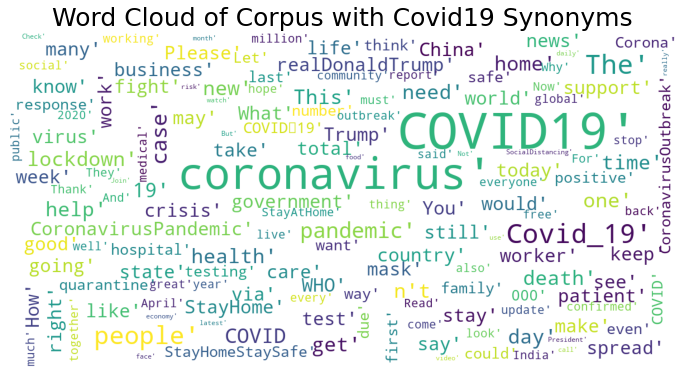

In [16]:
show_wordcloud(corpus_LDA_with_Covid19_synonyms, "Word Cloud of Corpus with Covid19 Synonyms")

We can see above that (as expected) the most common tokens are synonyms of Covid19. However, there are other, quite interesting, tokens also present. In terms of countries we can see India (bottom right) and China (top centre)  which is also expected as in the early days of Covid19, China was regularly in the news as it was battling the rampant spread of the virus. The 'mentions' of realDonaldTrump and Trump are likely present as he was the president of USA during the timeframe we are analyzing (March-April 2020). The corpus has a bias present due to filtering on English Tweets and majority of the English Tweets come from USA. <a href="https://www.statista.com/statistics/242606/number-of-active-twitter-users-in-selected-countries/">The Statista website</a> shows that USA has the highest Twitter presence. Even though the linked data is from January 2021, the presence hasn't changed massively since March/April 2020 (especially when it comes to Enlgish Tweets).

Some of the tags outline the trending hashtags from the period such as 'StayHomeStaySafe', 'StayHome' or 'StayAtHome' which were the prevalent views for decreasing the chance of contracting Covid19. We can also see entities such as 'WHO' which stands for the World Health Organisation, an entity which was prominent in broadcasting news and guidelines to countries on effective steps to take for  decreasing the spread of Covid19. Finally, the other major tags include 'spread', 'lockdown', 'mask', 'hospital', 'health', 'testing', 'death' and 'patient' which all are a grim reminder of the conditions being discussed in the social media at the time. 

We have seen an initial analysis of the most frequent terms in our corpus. Now let's use LDA to conduct Topic Modeling. As discussed earlier, Topic modeling is done by describing topics through clustering word patterns which are similar and counting their frequencies. The model can cluster different words together as it learns the word frequencies and which words are likely to appear in the same document.

### LDA Model 1 and its Visualization <a id="4"></a>

The PyLDAvis model visualization requires 4 inputs:
 - The corpus being used
 - A dictionary of mapping between words and their integer identification number 
 - A bag of words based on the corpus being used
 - LDA Model with assigned number of topics
 
#### Generating Model and Relevant Visualization Objects - Model 1
We start with converting our corpus into a dictionary where the words are mapped with their integer identification number. This will then be used to generate a bag of words, which is a list of tuples (word_id, word_frequency). The bag of words ensures that the full list of tokens and their frequency is numerical and ready to be used in the model. The gensim.corpora.Dictionary will be utilized for generating the dictionary (dic) and bag of words (bow_corpus). The bag of words and dictionary will in turn be used to generate the LDA model (lda_model) with a pre-specified number of topics. 

As this process will be utilized multiple times throughout the project, we will convert this into a function which gives the 3 required outputs (dic, bow_corpus and lda_model) which in turn can be assigned to variables. This function will be called 'get_lda_objects' and is defined below.

In [17]:
# Function to automatically get relevant lda objects for plotting LDA visualization
def get_lda_objects(corpora, topics=4):
    
    """
    The function takes 2 inputs:
         - The corpus which is being used for LDA modeling
         - An integer which refers to the number of topics which should be plotted (defualt is 4)
        
    The function returns 3 variables:
        - Dictionary of the mapping of words and their identifications integer
        - Bag of words corpus based on the corpus input into the equation
        - LDA model with pre-specified number of topics
    
    A Random state of 13 has been added to ensure reproducibility  of LDA model
    
    """
    
    # Ensure that variable 'topics' is an integer
    assert isinstance(topics, int), "Input variable 'topics' should be an integer"
    
    # assigning dic to the dictionary mapping being created using gensim's Dictionary
    dic=gensim.corpora.Dictionary(corpora)
    
    # Bag of words generated by taking each word in the dictionary and using the doc2bow method from gensim's dictionary
    bow_corpus = [dic.doc2bow(doc) for doc in corpora]
    
    # LDA model being generated using the dictionary, bag of words and either 4 or a pre-specified number of topics 
    lda_model = gensim.models.LdaMulticore(bow_corpus, 
                                       num_topics = topics, 
                                       id2word = dic,                                    
                                       passes = 10,
                                       random_state=13,
                                       workers = 2)
    return lda_model, bow_corpus, dic


Let's use the function below to get an LDA model with 5 topics. This is will be our first model and provide a good base case to start with. The number of topics is chosen as 5 because the author's research showed that a lower number of topics usually provide better uniqueness and better interpretability. The dictionary, bag-of-words corpus and LDA model we receive will contain the suffix 'with_Covid19_synonyms' to decrease confusion in future workflows. 

In [18]:
# using the get_lda_objects function to get objects for a 5 topic LDA model. 
lda_model_with_Covid19_synonyms, bow_corpus_with_Covid19_synonyms, dic_with_Covid19_synonyms = get_lda_objects(corpus_LDA_with_Covid19_synonyms, 5)

#### Viewing Topics in Model 1
Below we can use the `show_topic()` method in the LDA model to see all the topics and the top 10 words associated with that topic. The words are displayed as a tuple with the weightage for the word in the topic.  

In [19]:
pprint(lda_model_with_Covid19_synonyms.show_topics(formatted=False))

[(0,
  [('COVID19', 0.037067648),
   ('coronavirus', 0.013217479),
   ('pandemic', 0.008288754),
   ('The', 0.007853631),
   ('help', 0.006548972),
   ('covid19', 0.006124302),
   ('health', 0.0051278346),
   ('support', 0.004846143),
   ('need', 0.0042639878),
   ('worker', 0.004104302)]),
 (1,
  [('coronavirus', 0.00970312),
   ('via', 0.007831253),
   ('YouTube', 0.0059652193),
   ('Trump', 0.0037614717),
   ('StayHomeStaySafe', 0.0032852748),
   ('covid19', 0.0031356167),
   ('Coronavirus', 0.0030840223),
   ('COVID19', 0.0028989788),
   ('Sign', 0.002115912),
   ('realDonaldTrump', 0.0015936331)]),
 (2,
  [('COVID19', 0.012097065),
   ('Support', 0.0068840315),
   ('THE', 0.006782096),
   ('Last', 0.0051879915),
   ('YOU', 0.004456464),
   ('deliver', 0.0043938267),
   ('delivered', 0.004174694),
   ('official', 0.004059722),
   ('copy', 0.0031322346),
   ('signing', 0.00299744)]),
 (3,
  [('COVID19', 0.028364666),
   ('coronavirus', 0.021325974),
   ('Covid_19', 0.009794488),
   

Note: Every time the model is rerun, some of the words may change in the display above. However majority of the words will be present and hence still give an understanding of the overall topic.

From the output above it is evident that most topics contain different synonyms of Covid19 in their top words, however the remaining words can give a better understanding. 

- Topic 0 shows words such as 'help', 'support', 'need' and 'crisis' which may point to the more emotionally charged Tweets with pleas of help and support required to deal with the pandemic. The presence of 'THE' suggests the need for changing corpus to lowercase such that it will be filtered as a stop word.

- Topic 1 shows words such as 'StayHomeStaySafe' but also 'Trump' and 'realDonaldTrump' and 'YouTube'. This is interesting as it may point to more politics related topics specific to USA. The mention of 'Youtube' may show that it was a discussed word, likely because a lot of the information was being gathered by people using this social media platform.  

- Topic 2 shows words such as 'THE', 'Support', 'Last', 'YOU', 'deliver','official', 'copy', 'signing' etc. But these don't point to a specific topic  and instead suggest  the need for using all lowercase words for Topic Modeling. This is because then 'THE' and 'YOU' would be filtered as a stop words.

- Topic 3 shows words such as 'people', 'time', 'get', 'like' with multiple synonyms of Covid19. This seems to be a generic topic with the different Covid19 synonyms being used together in a Tweet.

- Topic 4 shows words such as 'case', 'death', 'new', 'lockdown', and 'positive' which likely refer to the number of cases, deaths and lockdown measures that were being discussed using Twitter.

While this method of understanding the topic is simple, it provides very little in-depth information. It would be preferred to visualize more words related to the topic. We can use the `gensimvis.prepare` method (also known as PyLDAvis) to get an in-depth visualization of the topics being discussed. The method requires an LDA model, bag of words corpus and a dictionary formed by the corpus to make the visualization. We have created those variables above using the `get_lda_objects()` function. 

#### PyLDAvis Plot of Topics Model 1 <a id="5"></a>

Let's create a function that can automatically plot the the LDA visualization for us. This function will take the 3 outputs of the `get_lda_objects()` function and plot the visualization for us. 

In [20]:
# Defining the function that will automatically plot the LDA model
def plot_lda_vis(lda_model, bow_corpus, dic):
    """
    The function accepts the LDA model, bag of words corpus and a dictionary formed by the LDA model corpus to generate a visualization for the LDA model
    
    """
    # Enable pyLDAvis in Jupyter Notebook
    pyLDAvis.enable_notebook()
    
     # Create the variable vis which can be used to show the visualization 
    vis = gensimvis.prepare(lda_model, bow_corpus, dic)
    
    # Return vis to show visualization 
    return vis

Let's use the function to visualize our 5-topic LDA model by putting in the relevant variables.

In [21]:
plot_lda_vis(lda_model_with_Covid19_synonyms, bow_corpus_with_Covid19_synonyms, dic_with_Covid19_synonyms)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.212713  0.087038       1        1  40.454677
0     -0.206193  0.063236       2        1  32.212259
4     -0.030540 -0.254188       3        1  16.259106
1      0.203423  0.041676       4        1   6.167513
2      0.246023  0.062239       5        1   4.906445, topic_info=                  Term          Freq         Total Category  logprob  loglift
119               case   5590.000000   5590.000000  Default  30.0000  30.0000
450              death   4244.000000   4244.000000  Default  29.0000  29.0000
88         Coronavirus   7163.000000   7163.000000  Default  28.0000  28.0000
129                n't   4495.000000   4495.000000  Default  27.0000  27.0000
7          coronavirus  22425.000000  22425.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
94                 You    131.164500   1959.629383   Topic5  -6.2445   0.3106
848                Why    112.483307    972.896778   Topic5  -6.3982   0.8571
489                Now    102.322603    850.993121   Topic5  -6.4929   0.8963
1755  StayHomeStaySafe    106.580542   1655.198254   Topic5  -6.4521   0.2718
776                NOW     85.047194    241.019339   Topic5  -6.6778   1.9729

[317 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
296       1  0.179989   2020
296       2  0.268405   2020
296       3  0.486286   2020
296       4  0.064733   2020
7340      1  0.311662    ALL
...     ...       ...    ...
615       1  0.689172  world
615       2  0.295179  world
615       3  0.015558  world
418       1  0.984313  would
418       2  0.015216  would

[458 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 2, 3])

##### Understanding the PyLDAvis Plot
This visualization may look quite complex, however it is quite simple and easy to use once it has been explained. One of the main advantages of this visualization is that it gives each user the ability to explore the model themselves, rather than  relying solely on the author to give their perspective of the analysis.

The model visualization is incredibly interactive and these are the different components to analyze the model:

 - The right side of the plot shows the top 30 most salient terms for the whole corpus when no topic is specifically selected. Saliency is not only a measure of how frequently the term is used but also how important it is in the corpus for detecting a topic.
     - The horizontal bar in front of each word shows the number of times the word was present in the overall corpus.
     - Each word in the graph can be selected to see which topics it occurs in and how important of a role it plays in that topic. The corresponding topics on the left hand side will either:
         - Increase in size if the word is used a lot in the topic;
         - Decrease in size if the word is not used as much in the topic;
         - Close altogether if the word doesn't occur in the topic at all.
         
         
 
 - The left side of the plot shows a global perspective of the topics generated by the model. The centres of the bubbles are determined by computing the Jensen–Shannon divergence between topics, and then by using multidimensional scaling to project the inter-topic distances onto two dimensions:
     - The size of the bubbles indicate the relative prevalences of the topics  in the corpus;
     - The location of the bubble shows how different or similar the topics are from each other.
     

 - If the 2 sides are used together then the insights are even better:
     - If you hover over a topic bubble on the left panel, then the terms on the right panel change to show the use of words in that topic bubble. It also shows how many times the words are used in the topic (red bar) versus how many times the word is used in the overall corpus (Blue bar);
     - If you click the topic bubble on the left panel, then it remains selected while showing the most used words on the right panel. The `Slide to adjust relevance metric` slider can then be used to check the relevance of the words in the topic to the overall corpus. By default, the terms of a topic are ranked in decreasing order according to their topic-specific probability ( λ (Lambda) = 1 ). Higher Lambda values (towards right side of the slider) relate to words that have *high relevance in the overall corpus while being present in the selected topic*. Lower Lambda values (towards left side of the slider) show words *relevant to the topic specifically, regardless of them being important in the overall corpus*.  The suggested “optimal” value of Lambda for seeing a *mixture of relevant topic terms and their relation to the  overall corpus* is λ = 0.6.
 
 - Notes:
     - Clicking or hovering over a topic bubble on the left panel can show the percentage of tokens used in that topic. This is seen in the heading of the right panel.
     - The number of terms in the right panel (x-axis) is only relevant when the λ = 1. If the Lambda value is changed, then the number of terms on x-axis is irrelevant, implying that at lower Lambda values the term bar displays are only relative. 
     - Any topic can be de-selected by clicking in the empty non-topic area between the topic bubbles on the left panel. 
     - Over the left panel there is an alternative method to go over each topic by either writing the topic number in the box or clicking Next/previous topic. A selected topic can be unselected by clicking 'Clear Topic'.
     - Every time the model is regenerated with a specific number of topics, the coherence score has chances of changing by ~<1%. Furthermore, the words in the topics may change a little bit. This is a higher probability for smaller topics. 

The descriptions of the use have incorporated several lines from the original paper <a href="https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf"> (Sievert and Shirley (2014))</a> , the designer of the model visualizer. The papers from the authors of the original LDA model and the visualization creators are available on the bottom right hand side of the plot as reference. 

#### Analyzing Topics in Model 1 using PyLDAvis Plot
For classifying a topic, the topic will be selected on the left panel with the `Slide to adjust relevance metric` set to λ = 0 to see the most relevant words in the corresponding topic. If that doesn't give enough topic related information, then the slider will be adjuster to higher Lambda values (mentioned in bracket below), to gauge the topic in context of the global corpus. As mentioned earlier, some of the lower relevance words may change for the topic when the model is re-run. However majority of the topic words will be the same.

Note: The PyLDAvis topics are not going to correspond to the topics 0-4 printed earlier using the `pprint`. For example the topic 1 earlier (0 indexing) mentioning Donald Trump will not be related to Topic 2 here (non zero indexing). Essentially, PyLDAvis is an improvement on the Topic Recognition methodology.

- Topic 1 (~40% tokens)  shows words such as 'think', 'thing', 'really' as top words with λ = 0. As these words are not very descriptive of the topic, we will increase the Lambda to 0.6. The words in this panel include 'Trump' and 'realDonaldTrump' and when we hover over these terms (on the right panel), we can see that they play a big role in Topic 1 (while also appearing in topic 4 to a smaller extent). There are also synonyms of COvid19 present in the topic. All of this now points to the topic being related to the American Covid19 related Tweets which also included a lot of discussion of the presidential election.  


- Topic 2 (~32% tokens) shows words such as 'business', 'support', 'impact', 'global' and 'economic' with λ = 0. This points toward more global business and economics related topics such as discussions related to impacts of Covid19 on global economy. 


- Topic 3 (~16% tokens)  shows words such as 'case', 'India', 'total', 'confirmed', 'narendramodi', 'Ramadan', 'PMOIndia', 'Spain', 'Pakistan', 'France' and 'Iran' with λ = 0. These terms point to a topic related to countries which had high Covid19 rates at the time as well as Indian politics. 


- Topic 4 (~6% tokens) shows words such as 'Youtube', 'IngrahamAngle', 'MAGA', 'Joe', 'PressBriefing' among others with λ = 0, which point to social media and news coverage.


- Topic 5 (~5% tokens) shows words such as 'the', 'support', 'last', 'you', and 'positive' with λ = 0 which don't point to a specific topic. Even with higher  values (upto 1) of Lambda, there is no increase in specificity of the topic. This means that topic 5 likely contains the terms that didn't fit in the other topics. It is also obvious that the tokens need to be turned into lowercase to avoid repetition of terms. 


#### Evaluating LDA Model 1

**Coherence Score** <a id="6"></a>

While the model looks quite good, we have not actually evaluated how well the model has worked for distributing the words related to the topics. The evaluation of topic models is done using a coherence score. A set of statements or facts is said to be coherent, if they support each other. Topic Coherence measures score of a topic by evaluating the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference. More details on estimating model coherency can be found <a href="https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0"> here</a>. 

The `get_coherence()` method can be used on a `CoherenceModel` to determine the model coherency. The coherence model is built using a the original LDA model, corpus used to generate the LDA model and the dictionary formed while generating the LDA model. A function is defined below to compute the coherence score based on these variables. 

In [22]:
# Compute Coherence Score
def compute_coherence_score(lda_model_name, text_name, dictionary_name):
    """
    The function takes:
     - lda_model
     - corpus for generating the lda model
     - dictionary used to generate the lda model 
    
    It then instantiates the CoherenceModel using this information and uses the get_coherence method to get the coherence score. 
    
    """
    # Instantiate the Coherence model using lda model, corpus and dictionary name
    coherence_model_lda = CoherenceModel(model=lda_model_name, texts=text_name, dictionary=dictionary_name, coherence='c_v')
    
    # Use the relevant method to get the coherence score
    coherence_lda = coherence_model_lda.get_coherence()
    
    # Return the coherence score
    return coherence_lda

Let's use this function below to get the coherence score for our model. 

In [23]:
# Compute coherence score using predefined function and print it
score = compute_coherence_score(lda_model_with_Covid19_synonyms, corpus_LDA_with_Covid19_synonyms, dic_with_Covid19_synonyms)

print("The Coherence Score is: ", score)

The Coherence Score is:  0.3366841534258064


While the measure for model coherency is a great evaluation technique, it doesn't allow for gauging the randomness of words within a topic for the model. A potential method for gauging model randomness is given below.


**Mixture & Randomness Score Model 1** <a id="7"></a>

We might be able to assess how well our model is doing in terms of randomness of topics and the mixture of topic terms in a topic, by giving a 'Topic Randomness Score' (TRS) to each topic. The Mixture & Randomness Score (MRS) will be the final evaluation method and will work by assigning a TRS between 0, 0.5 and 1 for each topic. The sum of the TRS and base value (explained later) will then be divided by the number of topics in the model. This will ensure that the MRS is comparable between models. Overall, a lower MRS will represents lower randomness in topics and therefore a better model. The TRS will be based on the 30 terms on the right panel when a topic is selected and  λ = 0.  

The rules for assigning the TRS will be as follows:

 - TRS = 0:
     - If the topic shows a clear set of words which mostly point to 1 overall topic;
       
 - TRS = 0.5:
    - If the topic shows a mixture of words where some words point to 1 clear topic but then there are some random words included;
    - If the λ value has to be changed above 0 and upto 0.8 to understand the base topic;
    
 - TRS = 1:
    - If the topic shows a mixture of words where no 1 clear topic can be ascertained;
    - If the λ value has to be changed above 0 and to 0.8 or over to understand the base topic.
    
The base value for starting the calculation will be 1 for all models. Therefore, if a model has 5 topics and none of them have any randomness (sum TRS=0) then:
 - MRS = 1/5 = 0.2

However if a model with 10 topics has total TRS of 0 then:
 - MRS = 1/10 = 0.1

This system ensures that each model that is able to specify a higher number of topics with lower randomness, is given a representative score. 

Let's get the TRS for Model 1:
- Topic 1: The words  were not very descriptive of the topic and λ had to be increased upto 0.6 to understand the base topic:
    - TRS  = 0.5  

- Topic 2: Words are clear in describing base topic with λ = 0. 
     - TRS = 0


- Topic 3: Words are clear in describing base topic with λ = 0. 
     - TRS = 0


- Topic 4: Words are clear in describing base topic with λ = 0. 
     - TRS = 0


- Topic 5 Words are not descriptive and leading to 1 topic; λ had to be increased upto 1.0.
     - TRS = 1
     
Model 1 MRS  = (1(Base Value) + 0.5(Topic 1) + 0(Topic 2) + 0(Topic 3) + 0(Topic 4) + 1(Topic 5)) / 5 (Number of Topics)

In [24]:
# Calculate the MRS score
print("Model 1 MRS = ", (1+0.5+0+0+0+1)/5 )

Model 1 MRS =  0.5


The MRS should be represented in this manner:
 - MRS (in a range between : 'minimum MRS achievable by the model' to 'maximum MRS achievable by the model')
 
For Model 1 MRS is 0.5 as calculated above.

The Minimum MRS achievable by Model 1 is:
    - MRS(min)  = (1(Base Value) + 0(Topic 1) + 0(Topic 2) + 0(Topic 3) + 0(Topic 4) + 0(Topic 5)) / 5 (Number of Topics) = 0.2

The Maximum MRS achievable by Model 1 is:
    - MRS (max) = (1(Base Value) + 1(Topic 1) + 1(Topic 2) + 1(Topic 3) + 1(Topic 4) + 1(Topic 5)) / 5 (Number of Topics) = 1.2

The MRS for Model 1 will be displayed as follows: 0.5 (in a range between: 0.2 - 1.2)

It is understood that this is not a foolproof method, however it does give a good quantitative indication about how the model is performing in terms of topic identification and randomness associated with each topic.

### Model Results Table <a id="9"></a>

For this table, note that the "Coherence Score" column values may vary a small amount as they change ~1% for each model run. 



| Model Type (name) | Corpus Characteristics   | Number of Topics |  Coherence Score (%)  | Mixture & Randomness Score| Comments   |
|:------:|:------:|:------:|:------:|:------:|:------:|
|  LDA Model 1  |corpus_LDA_with_Covid19_synonyms | 5   |~35.0|0.5 (in a range between: 0.2 - 1.2)| Model seemed to fit well to the corpus however 1 topic lacked specificity leading to the given MRS.  | 

#### Optimizing LDA Model 1
As we can see above, the coherence score is not the best. Let's change the number of topics and see whether we can get a better coherence score. We will use a `for` loop to check approximately how many topics give the best result. It should be noted that the number of topics for this part is intentionally kept lower as each model takes a long time to run, especially with higher number of topics. Therefore, the approach used is to gauge the best score using a wide spacing for the number of topics, and then check the closer topic number spacing once we have a clear understanding of approximately which range of  topics gives the highest coherence. 

The initial range for topics is from 5 to 100 with steps of 25, therefore LDA models and scores will be generated for models with 5, 30, 55 and 80 topics. 

In [25]:
# Create empty lists to append to for plotting the number of topics and their coherence scores
topic_with_Covid19_synonyms = []
coherence_with_Covid19_synonyms = []

# Start the for loop with our range
for i in range(5,100,25):
    
    # Use predefined function to generate the relevant objects for creating an LDA model, with the number of topics changing according to our range
    lda_model, bow_corpus, dic  = get_lda_objects(corpus_LDA_with_Covid19_synonyms, topics=i)
    
    # Use predefined function to generate score using the generated objects and corpus
    score = compute_coherence_score(lda_model, corpus_LDA_with_Covid19_synonyms, dic)
    
    # Append the number of topics to the relevant list
    topic_with_Covid19_synonyms.append(i)
    
    # Append the score to the relevant list
    coherence_with_Covid19_synonyms.append(score)

Let's check the number of topics and their corresponding scores by plotting them below. 

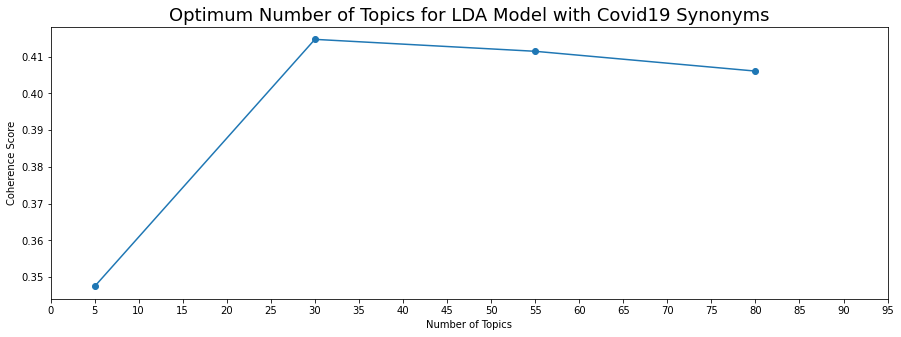

In [26]:
# Instantiate the figure
plt.figure(figsize=(15,5))

# Plot the topics and their coherence scores
plt.plot(topic_with_Covid19_synonyms, coherence_with_Covid19_synonyms, marker='o')

# Get the relevant number of ticks
plt.xticks(np.arange(0,100,5))

# Make the plot more comprehensible
plt.title("Optimum Number of Topics for LDA Model with Covid19 Synonyms", size = 18)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

# Show the plot
plt.show()

We can see that around 30 topics we get the best coherence score with a reasonable number of topics. Now let's use a similar `for` loop with a smaller topic spacing near 30 to see the best number of topics relating to the highest coherence score. The range for topics is from 5 to 40 with steps of 5, therefore LDA models and scores will be generated for models with 5, 10, 15, 20, 25, 30 and 35 topics.

In [27]:
# Create empty lists to append to for plotting the number of topics and their coherence scores
topic_with_Covid19_synonyms = []
coherence_with_Covid19_synonyms = []

# Start the for loop with our range
for i in range(5,40,5):
    
    # Use predefined function to generate the relevant objects for creating an LDA model, with the number of topics changing according to our range
    lda_model, bow_corpus, dic  = get_lda_objects(corpus_LDA_with_Covid19_synonyms, topics=i)
    
    # Use predefined function to generate score using the generated objects and corpus
    score = compute_coherence_score(lda_model, corpus_LDA_with_Covid19_synonyms, dic)
    
    # Append the number of topics to the relevant list
    topic_with_Covid19_synonyms.append(i)
    
    # Append the score to the relevant list
    coherence_with_Covid19_synonyms.append(score)

Let's check the number of topics and their corresponding scores by plotting them below. 

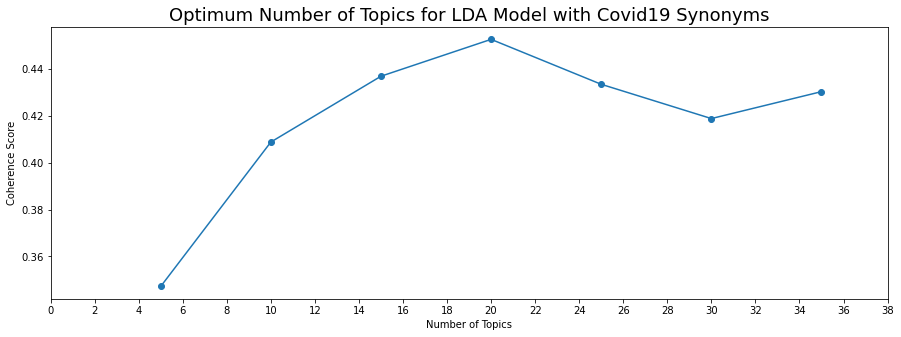

In [28]:
# Instantiate the figure
plt.figure(figsize=(15,5))

# Plot the topics and their coherence scores
plt.plot(topic_with_Covid19_synonyms, coherence_with_Covid19_synonyms, marker='o')

# Get the relevant number of ticks
plt.xticks(np.arange(0,40,2))

# Make the plot more comprehensible
plt.title("Optimum Number of Topics for LDA Model with Covid19 Synonyms", size = 18)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")

# Show the plot
plt.show()

We can see that 20 topics gives us the best result so let's plot a model with 20 topics. While the variable names are long, they are descriptive. This is necessary to keep track of the different models and the changes made. Below, we will generate the model using the `get_lda_objects()` function.

###  LDA Model 2 and its Visualization <a id="8"></a>

In [29]:
# Generate an LDA model and corresponding objects with 20 topics
lda_model_with_Covid19_synonyms_with_20topics, bow_corpus_with_Covid19_synonyms_with_20topics, dic_with_Covid19_synonyms_with_20topics = get_lda_objects(corpus_LDA_with_Covid19_synonyms, 20)

#### Viewing Topics in Model 2
We can print the topics below, however the `pprint` utility only prints 10 topics at a time. If the number of topics is higher than 10, then it will randomly choose 10 topics and show the terms related to them. 

In [30]:
# Print the terms in the topics
pprint(lda_model_with_Covid19_synonyms_with_20topics.show_topics(formatted=True))

[(5,
  '0.046*"COVID19" + 0.016*"health" + 0.014*"help" + 0.013*"worker" + '
  '0.012*"need" + 0.012*"support" + 0.009*"care" + 0.009*"pandemic" + '
  '0.009*"coronavirus" + 0.008*"The"'),
 (15,
  '0.049*"case" + 0.041*"COVID19" + 0.034*"death" + 0.029*"coronavirus" + '
  '0.021*"new" + 0.018*"Coronavirus" + 0.014*"positive" + 0.013*"test" + '
  '0.013*"number" + 0.011*"April"'),
 (12,
  '0.047*"Coronavirus" + 0.042*"COVID19" + 0.037*"Trump" + 0.029*"coronavirus" '
  '+ 0.024*"realDonaldTrump" + 0.022*"The" + 0.021*"via" + 0.014*"Pandemic" + '
  '0.012*"News" + 0.010*"YouTube"'),
 (2,
  '0.009*"USPS" + 0.009*"stayhomestaysafe" + 0.009*"extra" + '
  '0.007*"ChineseVirus" + 0.007*"brand" + 0.006*"WuhanVirus" + '
  '0.006*"ChinaVirus" + 0.006*"CCPVirus" + 0.006*"covered" + '
  '0.005*"ChinaLiedPeopleDied"'),
 (3,
  '0.035*"COVID19" + 0.025*"coronavirus" + 0.016*"people" + 0.016*"n\'t" + '
  '0.011*"Covid_19" + 0.010*"like" + 0.009*"The" + 0.009*"get" + 0.007*"know" '
  '+ 0.007*"one"'),
 

We can interpret some of the topics in the model using the terms above but it would be better to use the LDA visualization. However, first let's check the coherence score for our model with 20 topics.  

#### Evaluating LDA  Model 2 <a id="10"></a>

In [31]:
# Compute coherence score using predefined function
compute_coherence_score(lda_model_with_Covid19_synonyms_with_20topics, corpus_LDA_with_Covid19_synonyms, dic_with_Covid19_synonyms_with_20topics)

0.4393796519407741

The coherence score has improved by ~10%! The visualization will now be plotted below to see the topics and their distribution. We will be using the `plot_lda_vis()` function for this. 

#### PyLDAvis Plot and Topic Identification -  Model 2 <a id="9"></a>

In [32]:
# Plot the lda model using a predefined function 

plot_lda_vis(lda_model_with_Covid19_synonyms_with_20topics, bow_corpus_with_Covid19_synonyms_with_20topics, dic_with_Covid19_synonyms_with_20topics)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.314732  0.039721       1        1  20.462893
5      0.265616  0.042565       2        1  11.003754
9      0.252849 -0.004986       3        1  10.456774
15     0.178526 -0.234675       4        1   9.067607
16     0.207724 -0.100557       5        1   7.689831
19     0.183607  0.182605       6        1   6.801846
18     0.143625  0.185907       7        1   5.734472
12     0.055484 -0.139562       8        1   4.446363
8     -0.020290 -0.047887       9        1   3.300746
10    -0.078767  0.031008      10        1   2.654126
17    -0.124497  0.003098      11        1   2.189401
4     -0.126309 -0.018632      12        1   2.113077
6     -0.128068 -0.051622      13        1   2.060339
7     -0.119690 -0.012150      14        1   2.041557
13    -0.140525  0.023286      15        1   1.970352
0     -0.161782  0.019101      16        1   1.868327
11    -0.154594  0.011108      17        1   1.771746
14    -0.150904  0.031340      18        1   1.757756
1     -0.197189  0.019781      19        1   1.335913
2     -0.199547  0.020550      20        1   1.273118, topic_info=                   Term          Freq         Total Category  logprob  loglift
119                case   6264.000000   6264.000000  Default  30.0000  30.0000
450               death   4753.000000   4753.000000  Default  29.0000  29.0000
88          Coronavirus   8185.000000   8185.000000  Default  28.0000  28.0000
12                 home   3329.000000   3329.000000  Default  27.0000  27.0000
21              COVID19  42480.000000  42480.000000  Default  26.0000  26.0000
...                 ...           ...           ...      ...      ...      ...
19980            George     59.762789     63.274733  Topic20  -5.6815   4.3066
7133   stayhomestaysafe    161.768238    267.902520  Topic20  -4.6857   3.8592
1422            nytimes     89.947974    192.338940  Topic20  -5.2727   3.6037
10180               gap     54.598846     59.682421  Topic20  -5.7719   4.2747
4516             Street     55.660841     75.493674  Topic20  -5.7526   4.0589

[1050 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1519     14  0.985855     150
439      13  0.990241  20,000
296       1  0.047777    2020
296       3  0.107860    2020
296       4  0.668155    2020
...     ...       ...     ...
2184      1  0.995437   worse
418       1  0.947910   would
418       5  0.042479   would
418       6  0.009069   would
4509      1  0.998110   wrong

[1839 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 10, 16, 17, 20, 19, 13, 9, 11, 18, 5, 7, 8, 14, 1, 12, 15, 2, 3])

#### Analyzing Topics in Model 2 using PyLDAvis Plot
A brief look at the plot shows that there are several separated topics as well as several smaller clusters of topics. We will attempt to classify the biggest topics that we have and 2 smaller topics to see what they reveal in terms of the LDA model competency. For classifying a topic, the topic will be selected on the left panel with the `Slide to adjust relevance metric` set to λ = 0 to see the most relevant words in the corresponding topic (if it is changed then it will be mentioned in the explanation). As mentioned earlier, some of the lower relevance words may change for the topic when the model is re-run. However majority of the topic words will be the same. 


 - The most salient words in the corpus (default right panel when no topic is selected) are very similar to our last model of 5 topics. The top salient terms are 'case' and 'death' followed by synonyms of Covid19. The saliency of the synonyms may stem from a particular synonym being used in a specific contest, for example 'coronavirus' may be used by news outlets while 'covid19' may be used in a normal Tweet from a mass user.   
 
     
 - Topic 1 (~20.7% tokens) shows words such as 'think', 'kill', 'cure', 'bad', 'saying', 'anything', 'truth', 'blame' and 'politician' which may point to the more emotionally charged Tweets that are trying to spread panic or question the reality of the pandemic. However it seems semi random.
 
 
 - Topic 2 (~11% tokens) shows words such as 'worker', 'healthcare', 'emergency', 'ensure', 'medical', 'equipment', 'responder', and 'caring' which may point to the Tweets discussing the frontline workers, hospitals etc.
 
  
  - Topic 3 (~10.4% tokens) shows words such as 'Check', 'webinar', 'discuss', 'virtual', 'blog', 'information', 'website', 'learned' and 'volunteer' which may point to the Tweets discussing the online learning or volunteer groups. This may show the prevailing thought process at the time where people were encouraging each other to make use of the lockdown by learning new skills online. 
  
- Topic 4 (~9% tokens) shows words such as 'positive', 'total', 'confirmed', 'reported', 'Cases', 'toll', 'deaths', 'recovered' and 'CoronaVirusUpdates' which clearly point to the Tweets discussing the daily updates with the regular counts of tracking the cases. 
 
 
- Topic 5 (~7.7% tokens) shows words such as 'tax', 'bill', 'price', 'loan', 'stock', 'opening', 'flight', 'oil', 'trade', 'bank', 'budget' which may point to the Tweets discussing the business news in regards to finance and industries affected such as oil and airlines. Furthermore, the stock market saw a crash right before the Tweets were collected and throughout the collection period, the stock market saw a rapid increase with stock market trading on the rise among US citizens. The budgetary decisions for stimulus checks during this period is also represented. 


- Topic 6 (~7% tokens) shows words such as 'kid', 'Hey', 'shit', 'episode', 'prayer', 'TrumpLiesAmericansDie', 'bleach', 'wife', 'brother', 'rich' and 'NHSheroes'. These words in the topic seem to be incredibly random. It ranges from 'kid', 'TrumpLiesAmericansDie' to 'episode' and swear words. 


- Topic 7 (~5.5% tokens) shows words such as 'home', 'mask', 'stay', 'safe', 'healthy', 'Boris', 'Johnson', 'facemask', 'MP's', 'Petition' and 'Masks4all'. These words in the topic seem to be pointing to British politics and pandemic protocols to stay safe. 


- Topic 8 (~4.5% tokens) shows words such as 'News', 'YouTube', 'CNN', 'briefing', 'FoxNews', 'DonalTrump', 'JoeBiden', 'BBC', 'FakeNews', 'Punjab' and 'MSNBC'. These words in the topic seem to be pointing to news media forums and specific news categories with a preference to American politics. The  term 'Punjab' may seem like a random outlier, however it was extensively covered in the news during those months. 


- Topic 9 (~3.5% tokens) shows words such as 'IndiaFightsCorona', 'Minister', 'narendramodi', 'Indian', 'Prime', 'Switzerland', 'Economic', 'PLEASE','STAY', 'HOME' and 'CoronavirusOutbreakIndia'. These words in the topic seem to be pointing to Indian Covid19 issues. 


- Topic 10 (~2.5% tokens) shows words such as 'distancing', 'corona', 'covid_19', 'meat', 'India', 'mouth', 'workout', 'beauty' and 'star'. These words in the topic seemed to be incorporating synonyms of Coviid19 but then turned quite random.   


- Topic 11 (~2.2% tokens) shows words such as 'South', 'Africa', 'Iran', 'France', 'Russia', 'Korea', 'Vietnam', 'severe', 'positive', 'vaccine' and 'clinical'. These words in the topic seem to be pointing to the different countries and possibly what their updates are, however it is somewhat unclear and hence somewhat random. 
  
  
- Topic 12 (~2.2% tokens) shows words such as 'THE', 'AND', 'THIS', 'FOR', 'ARE', 'QuarantineLife', 'immigration', 'sister', 'TRUMP', 'scared' and 'Fight'. These words in the topic seem to be stopwords that didn't get removed as they were all capitalized. We have to make all tokens lowercase to improve stopword filtering. There doesn't seem to be a topic this is pointing to at all and is hence, completely random.


- Topic 13 (~2.1% tokens) shows words such as 'app', 'help', 'slow', 'Download', 'BillGates', 'Amazon', 'self-reporting', 'Kano', 'smallbusiness', 'Republican' and 'stoppping'. These words in the topic seem to be hinting towards big businesses with Bill Gates and Amazon however even with using a λ = 1, there is no increase in topic coherence and is hence, completely random.


- Topic 14 (~2% tokens) shows words such as 'hand', 'water', 'Crisis', 'wash', 'WashYourHands', 'photography', 'Wash', 'soap', 'memory', 'ArvindKejriwal' and 'lockdownuk'. These words in the topic started off well with describing methodology to evade Covid19 by washing hands but then the topic disintegrated with random terms such as the Indian politician Arvind Kejriwal and lockdown in UK. Therefore this topic is deemed semi-random.


- Topic 15 (~1.9% tokens) shows words such as 'Nigeria', 'California', 'Governer', 'Lagos', 'Cuomo', 'Washington', 'collaboration', 'MBuhari', 'inmate', 'Executive' and 'guest'. These words in the topic started off by listing places but quickly disintegrated into randomness.
    
    
- Topic 16 (~1.8% tokens) shows words such as 'home', 'shop', 'Safe', 'worry', 'connection', 'WFH', 'powerful', 'Obama', 'alcohol', 'protesting' and 'Karnataka'. These words in the topic are quite random and show little association to each other, even with using a λ = 1.
    
  
- Topic 17 (~1.8% tokens) shows words such as 'Support', 'Last', 'deliver', 'copy', 'signing', 'Senator', 'Africans', 'CHINA', 'Vegas', 'CoronavirusIndia' and 'Oxford'. These words in the topic are quite random and show little association to each other, even with using a λ = 1.
  
      
- Topic 18 (~1.7% tokens) shows words such as 'COVID19Pandemic', 'Apr', 'Ontario', 'thread', 'Mumbai', 'WWG1WGA', 'Dubai', 'statistic', 'herd', 'Telangana' and 'collections'.These words in the topic started off by giving a hint of Covid19 update discussion but is overall very random.
     
    
 - Topic 19 (~1.3% tokens) shows words such as 'vote', 'election', 'Sweden', 'plant', 'Wisconsin', 'surprised', 'coffee', 'NFL', 'cleaner', 'StrongerTogether'. These words in the topic seem to be incredibly random. It ranges from 'vote', 'election' and 'Pelosi' to 'NFL', tags for solidarity and random words such as 'cleaner'.   
 
    
 - Topic 20 (~1.3% tokens) shows words such as 'extra', 'USPS', 'WuhanVirus', 'ChinaVirus', 'RishiSunak', 'commercial' and 'Indonesia'. These words are also quite random as they have everything from racist names for Covid19 used by Donald Trump, to British politicians and random mentions of 'commercial' and 'Indonesia'. 


The analysis of the words in the topics shows that there are well defined larger topics but also smaller clusters of non-coherent topics comprised of random words. For example, topics 14 onwards (overlapped on the left hand side of the left panel) seem to be a clustered and overlapping while incorporating small sub topics. We can see that while a higher number of topics improved our coherence score, it may have also increased model overfitting to the data, creating topics with random words and (ironically) leading to a decreased model coherency. This is especially apparent from the clustering of topics 14-20. It might be better to generate a model with fewer topics that model the differences in the data. This is a learning we can take forward to the next model that we generate.

**Mixture and Randomness Score Model 2** <a id="11"></a>

There seems to be a lot of randomness associated with the smaller topics in this model. Let's try to quantitatively measure that.

The TRS scores are given below

In [33]:
# Give a list of the topic randomness in sequence 1 onwards, defined earlier,  which will print them out according to each topic 
trs__model_2 = [0.5, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0.5, 1, 1, 0.5, 1, 1, 1, 1, 1, 1] 
for i, j in enumerate(trs__model_2):
    print(f'The TRS score for topic {i+1} is {j}')

The TRS score for topic 1 is 0.5
The TRS score for topic 2 is 0
The TRS score for topic 3 is 0
The TRS score for topic 4 is 0
The TRS score for topic 5 is 0
The TRS score for topic 6 is 1
The TRS score for topic 7 is 0
The TRS score for topic 8 is 0
The TRS score for topic 9 is 0
The TRS score for topic 10 is 1
The TRS score for topic 11 is 0.5
The TRS score for topic 12 is 1
The TRS score for topic 13 is 1
The TRS score for topic 14 is 0.5
The TRS score for topic 15 is 1
The TRS score for topic 16 is 1
The TRS score for topic 17 is 1
The TRS score for topic 18 is 1
The TRS score for topic 19 is 1
The TRS score for topic 20 is 1


The maximum and minimum possible MRS score is calculated below, followed by the actual MRS for Model 2.

In [34]:
# Calculate the MRS using 1 as the numerator and number of topics in the model as the denominator 
MRS_model_2_min = 1/20

print(f'The minimum possible MRS score for model 2 is: {MRS_model_2_min}')

The minimum possible MRS score for model 2 is: 0.05


In [35]:
# Calculate the MRS using number of topics + 1 as the numerator and number of topics in the model as the denominator
MRS_model_2_max = 21/20

print(f'The maximum possible MRS score for model 2 is: {MRS_model_2_max}')

The maximum possible MRS score for model 2 is: 1.05


In [36]:
# Calculate the MRS score in reference
MRS_model_2 = (sum(trs__model_2)+1)/len(trs__model_2)

print(f'The MRS score for model 2 is: {MRS_model_2} (in a range between {MRS_model_2_min} - {MRS_model_2_max}).')

The MRS score for model 2 is: 0.625 (in a range between 0.05 - 1.05).


### Model 1 and 2  Conclusions and Results Table

A [corpus was generated](#1) using Tweet preprocessing where the `stopwords` were removed followed by tokenization and lemmatization of the text. Furthermore, the `links`, `&amp`, `dashes` and `dots` [were removed](#2). All the Covid19 synonyms were left in place. A [WordCloud was generated](#3) which showed the most frequently occurring tokens in the corpus which were synonyms of Covid19. There were other representations such as:
     - Countries: 'India' and 'China'
     - Organisations: 'WHO'
     - People: 'Trump', 'realDonaldTrump'
     - Most Discussed Topics: 'Lockdown', 'mask', 'spread' and 'testing'
These are indicative of the Covid19 related topics being discussed in March/April 2020. 

The Topic Modeling for models 1 and 2 was conducted using the same corpus (explained above):
 - [Model 1](#4) was generated using 5 topics which all showed moderate separation and individuality while the topic words displayed a good relationship amongst them. We tested between printing the most relevant terms directly and [visualizing the topic terms using PyLDAvis](#5). The latter approach gave us a very comprehensive methodology for determining the topics. The topics also showed that the tokens will have to be turned into lowercase to avoid repetition of terms. Evaluation of the 1st model gave a [coherence score of ~35%](#6) and Mixture & Randomness Score [(MRS) is 0.5 (in a range between: 0.2 - 1.2)](#7).

 - [Model 2](#8) was generated after finding the optimum number of topics that would give the highest coherence score. This resulted in a [model with 20 topics](#9) and a [coherence score of ~45%](#10), which was an improvement of 10% over Model 1! While the increase in the number of topics gave a better representation to some topics, it also caused overfitting of the model leading to clustering of small topics with high randomness. This was displayed in MRS where the score for model 2 is [0.625 (in a range between: 0.05 - 1.05)](#11).
 
The modeling and evaluation of models 1 and 2 have given some great insights into methods which may improve model coherency and interpretability moving forward. These are listed below:
 - Make all terms lowercase in preprocessing;
 - The new corpus should change the synonyms for the word 'Covid' or 'Coronavirus' to a singular word;
 - Use PyLDAvis for topic evaluation;
 - The optimum model is not solely based on a coherence score but a balance of higher coherency and lower topic numbers to avoid overfitting. This will also be demonstrated by a lower MRS score.

The Topic Modeling related to the 2nd corpus will be covered in the next notebook. As the preprocessing differs for the next models, the data from the end of notebook 1 will be re-imported (as was done for this notebook).

Note: All the functions used in this part have been converted into scripts and saved so they can be called and used in the next part. In order to clarify the names of the function and their inputs, the scripts have been named in this specific format: 'function__name_of_function__input1andtype_input2andtype'.

### Model Results Table <a id="9"></a>

For this table, note that the "Coherence Score" column values may vary a small amount as they change ~1% for each model run. 


| Model Type (name) | Corpus Characteristics   | Number of Topics |  Coherence Score (%)  | Mixture & Randomness Score  | Comments   |
|:------:|:------:|:------:|:------:|:------:|:------:|
|  LDA Model 1  |corpus_LDA_with_Covid19_synonyms | 5   |~35.0|0.5 (in a range between: 0.2 - 1.2)| Model seemed to fit well to the corpus however 1 topic lacked specificity leading to the given randomness score.  | 
| LDA Model 2   | corpus_LDA_with_Covid19_synonyms|  20 | ~46.0| 0.625 (in a range between: 0.05 - 1.05) | Some topics showed high specificity however model seemed to overfit to the data. Lot's of small topic clusters with completely random terms. Undesirable even though higher Coherence Score as the MRS also increased.   |